# Modeling Heart Failure Prediction Success Rate

In this step of the Machine learning process, I will use the transformed and processed data to test how different 
ML models predict whether an individual is likely to have Heart Disease. I will use the different evaluation metrics to compare the models to find the most accurate ML model to predict Heart Disease in a person.

In [189]:
# Importing all the necessary libraries to build the ML models

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


print('done')

done


Creating a confusion matrix function to use later for the ML models

In [112]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [81]:
df = pd.read_csv('Data/Pre-Processed_data', index_col=0)
df

,FastingBS,HeartDisease,Sex_F,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,RestingECG_LVH,RestingECG_Normal,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,scaled_Age,scaled_RestingBP,scaled_Cholesterol,scaled_MaxHR,scaled_Oldpeak
0,0,0,0,0,1,0,0,1,0,0,1,0.244898,0.500000,0.393822,0.788732,0.295455
1,0,1,1,0,0,1,0,1,0,1,0,0.428571,0.666667,0.183398,0.676056,0.409091
2,0,0,0,0,1,0,0,0,0,0,1,0.183673,0.416667,0.382239,0.267606,0.295455
3,0,1,1,1,0,0,0,1,1,1,0,0.408163,0.483333,0.249035,0.338028,0.465909
4,0,0,0,0,0,1,0,1,0,0,1,0.530612,0.583333,0.212355,0.436620,0.295455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0,1,0,0,0,0,0,1,0,1,0,0.346939,0.250000,0.345560,0.507042,0.431818
914,1,1,0,1,0,0,0,1,0,1,0,0.816327,0.533333,0.208494,0.570423,0.681818
915,0,1,0,1,0,0,0,1,1,1,0,0.591837,0.416667,0.088803,0.387324,0.431818
916,0,1,1,0,1,0,1,0,0,1,0,0.591837,0.416667,0.291506,0.802817,0.295455


In [82]:
# Creating X and y variables for the train test split
y = df[['HeartDisease']]
X = df.drop('HeartDisease', axis=1)
# Changing the shape of y to fit (n_samples,)
y = y.values.ravel()
y.shape

FastingBS               int64
Sex_F                   int64
ChestPainType_ASY       int64
ChestPainType_ATA       int64
ChestPainType_NAP       int64
RestingECG_LVH          int64
RestingECG_Normal       int64
ExerciseAngina_Y        int64
ST_Slope_Flat           int64
ST_Slope_Up             int64
scaled_Age            float64
scaled_RestingBP      float64
scaled_Cholesterol    float64
scaled_MaxHR          float64
scaled_Oldpeak        float64
dtype: object

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 17, test_size = 0.3)

FastingBS               int64
Sex_F                   int64
ChestPainType_ASY       int64
ChestPainType_ATA       int64
ChestPainType_NAP       int64
RestingECG_LVH          int64
RestingECG_Normal       int64
ExerciseAngina_Y        int64
ST_Slope_Flat           int64
ST_Slope_Up             int64
scaled_Age            float64
scaled_RestingBP      float64
scaled_Cholesterol    float64
scaled_MaxHR          float64
scaled_Oldpeak        float64
dtype: object

First, I will create a Dummy Classifier to see what a random model will predict regarding Heart Disease

In [36]:
strategy = ["most_frequent", "prior", "stratified", "uniform"]

for strat in strategy:
    dummy_clf = DummyClassifier(strategy=strat)
    dummy_clf.fit(X_train, y_train)
    dummy_clf.predict(X_test)
    print(strat, dummy_clf.score(X_test, y_test))

most_frequent 0.5434782608695652
prior 0.5434782608695652
stratified 0.5362318840579711
uniform 0.47101449275362317


About a 50/50 split with the Dummy Classifier and now I have a comparison for all of my other models

### Logistic Regression

In this section, I am going to use a Logistic Regression model to to predict Heart Failure. I have created a parameter grid to feed to my GridSearchCV object. I will use the GSCV to find the optimal parameters for a Logistic Regression model for this dataset and use the optimal parameters with an RFECV object to find the optimal feature number and names. I will then drop the least important features and run a new Logistic Regression model for the dataset.

In [94]:
log_reg = LogisticRegression()

grid_params  = [
    {'solver' : ['saga'],
      'penalty' : [ 'l1', 'l2', 'none'],
      'max_iter' : [50,100,200,500,1000,2500],
      'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    {'solver' : ['newton-cg', 'lbfgs', 'sag', 'newton-cholesky'],
      'penalty' : ['l2','none'],
      'max_iter' : [50,100,200,500,1000,2500],
      'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
     {'solver' : ['liblinear'],
      'penalty' : ['l2','l1'],
      'max_iter' : [50,100,200,500,1000,2500],
      'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    ]

In [95]:
gscv = GridSearchCV(log_reg, param_grid = grid_params, cv=3, verbose=True, n_jobs=-1, error_score=0.0)
best_model = gscv.fit(X_train,y_train)

best_model.best_estimator_

Fitting 3 folds for each of 546 candidates, totalling 1638 fits


/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

LogisticRegression(C=1, max_iter=50, penalty='l1', solver='liblinear')

The best hyper paremeters for a Logistic Regression model are C=1, max_iter=50, penalty='l1', solver='liblinear'. 

I will use these parameters in the RFECV object below to find the best number of features and the feature names.

In [154]:
rfecv = RFECV(estimator=LogisticRegression(C=1, max_iter=50, penalty='l1', solver='liblinear'), step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2)
rfecv.fit(X_train,y_train)
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Ranking of features: {rfecv.ranking_}")
print(f"Optimal name of features: {rfecv.feature_names_in_}")
feat_df = pd.DataFrame(rfecv.ranking_,rfecv.feature_names_in_)
feat_df

85.5072463768116
Optimal number of features: 11
Ranking of features: [1 1 1 1 1 5 2 1 1 1 1 4 3 1 1]
Optimal name of features: ['FastingBS' 'Sex_F' 'ChestPainType_ASY' 'ChestPainType_ATA'
 'ChestPainType_NAP' 'RestingECG_LVH' 'RestingECG_Normal'
 'ExerciseAngina_Y' 'ST_Slope_Flat' 'ST_Slope_Up' 'scaled_Age'
 'scaled_RestingBP' 'scaled_Cholesterol' 'scaled_MaxHR' 'scaled_Oldpeak']


/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,0
FastingBS,1
Sex_F,1
ChestPainType_ASY,1
ChestPainType_ATA,1
ChestPainType_NAP,1
RestingECG_LVH,5
RestingECG_Normal,2
ExerciseAngina_Y,1
ST_Slope_Flat,1
ST_Slope_Up,1


Now that I have the best features and best parameters for this dataset to use with a Logistic Regression model. I will create a new Logistic Regression object and use the learned information from above to find how the model performs.

In [155]:
trained_df= df.drop(['RestingECG_LVH', 'RestingECG_Normal', 'scaled_RestingBP', 'scaled_Cholesterol'], axis=1)
y2 = trained_df[['HeartDisease']]
X2 = trained_df.drop('HeartDisease', axis=1)
y2 = y2.values.ravel()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 17, test_size = 0.3)
log_2 = LogisticRegression(C=1, max_iter=50, penalty='l1', solver='liblinear')
log_2.fit(X_train2, y_train2)
print('The train accuracy score', log_2.score(X_train2,y_train2))
print('The test accuracy score', log_2.score(X_test2,y_test2))
log_reg_proba = log_2.predict_proba(X_test2)
log_reg_proba = log_reg_proba[:,1]
print('')
print('Classification Report for Logistic Regression model')
print(classification_report(y_test2, log_2.predict(X_test2)))
print(log_2.classes_)

85.5072463768116
The train accuracy score 0.8689547581903276
The test accuracy score 0.855072463768116

Classification Report for Logistic Regression model
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       126
           1       0.86      0.87      0.87       150

    accuracy                           0.86       276
   macro avg       0.85      0.85      0.85       276
weighted avg       0.85      0.86      0.85       276

[0 1]


Looking at the evaluation above, we lost a small percent of accuracy from the train data and the test data but it is not statistically significant. The precision/recall/f1-score are about the same for the train and test set.

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

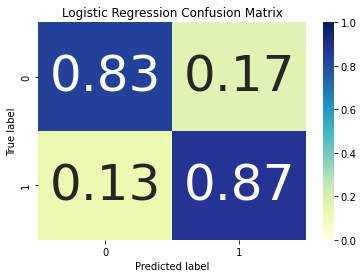

In [145]:
cm = confusion_matrix(y_test2, log_2.predict(X_test2))
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm, log_2.classes_)
plt.title('Logistic Regression Confusion Matrix')

The confusion matrix above tells us that we accurately predicted if an individual has Heart Disease 87% of the time and accurately predicted not having Heart Disease 83% of the time. The Logistic Regression model is better at predicting whether a person has Heart Disease than it is at predicting whether a person doesn't have Heart Disease. 

What worries me is that 13% of the time, when an individual truly has heart disease, the model predicts that they do not. This is not great because minimizing Type II errors while increasing True positive rate is the ideal scenario. Individuals shouldn't be told they don't have Heart Disease while they actually do.

In [146]:
# Here I will calculate the Log Loss metric for this model
print('Log Loss from train set: ',log_loss(y_train2, log_2.predict_proba(X_train2)))
print('Log Loss from test set: ',log_loss(y_test2, log_2.predict_proba(X_test2)))

Log Loss from train set:  0.3370852183871851
Log Loss from test set:  0.3339600363666478


Log Loss is about the same for both the train and test data set. 

# Random Forest Classifier

In this section, I will use a Random Forest Classifier to predict Heart Failure with the dataset. I will iterate through different hyper parameters using itertools to find the top hyper parameters for this dataset. I will then  create a new Random Forest Classifier with the top hyper parameters to predict how accurate this model is with the Heart Failure dataset.

In [148]:
from itertools import product

n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='gini', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=17)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))    

Classification accuracy on test set with max features = 1 and max_depth = None: 0.870
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.844
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.851
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.870
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.862
Classification accuracy on test set with max features = 1 and max_depth = 6: 0.870
Classification accuracy on test set with max features = 1 and max_depth = 7: 0.862
Classification accuracy on test set with max features = 1 and max_depth = 8: 0.870
Classification accuracy on test set with max features = 1 and max_depth = 9: 0.866
Classification accuracy on test set with max features = 1 and max_depth = 10: 0.862
Classification accuracy on test set with max features = 1 and max_depth = 11: 0.848
Classification accuracy on test set with max features = 1 and max_depth = 12: 0.85

Here, I ran the Random Forest Classifier with several different hyper parameters to find the best model. Max_depth of 5 was the best for all max_features except for max_features=1. The most accurate models were with max features as sqrt or log2 and with max depth of 5, score = 0.873.

Now, I will use the optimal hyper parameters to create an RFECV object to find the top features for use with this model.

In [149]:
rfecv2 = RFECV(estimator=RandomForestClassifier(n_estimators=100, 
                                criterion='gini', 
                                max_features='log2', 
                                max_depth=5, 
                                n_jobs=2,
                                random_state=17), step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2)
rfecv2.fit(X_train,y_train)
print(f"Optimal number of features: {rfecv2.n_features_}")
print(f"Ranking of features: {rfecv2.ranking_}")
print(f"Optimal name of features: {rfecv2.feature_names_in_}")
feat_df2 = pd.DataFrame(rfecv2.ranking_,rfecv2.feature_names_in_)
feat_df2.head(15)

Optimal number of features: 5
Ranking of features: [ 7  8  1  6  9 10 11  4  1  1  2  5  3  1  1]
Optimal name of features: ['FastingBS' 'Sex_F' 'ChestPainType_ASY' 'ChestPainType_ATA'
 'ChestPainType_NAP' 'RestingECG_LVH' 'RestingECG_Normal'
 'ExerciseAngina_Y' 'ST_Slope_Flat' 'ST_Slope_Up' 'scaled_Age'
 'scaled_RestingBP' 'scaled_Cholesterol' 'scaled_MaxHR' 'scaled_Oldpeak']


,0
FastingBS,7
Sex_F,8
ChestPainType_ASY,1
ChestPainType_ATA,6
ChestPainType_NAP,9
RestingECG_LVH,10
RestingECG_Normal,11
ExerciseAngina_Y,4
ST_Slope_Flat,1
ST_Slope_Up,1


I will drop all the columns that aren't ranked 1 and create a new train_test_split with the updated dataframe. I will then run a new Random Forest Classifier model with the top features and top hyper parameters to analyze how well this model predicts Heart Failure with the new dataset.

The train accuracy score 0.8861154446177847
The test accuracy score 0.8514492753623188

Classification Report for Random Forest model
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       126
           1       0.84      0.90      0.87       150

    accuracy                           0.85       276
   macro avg       0.85      0.85      0.85       276
weighted avg       0.85      0.85      0.85       276

[0 1]


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

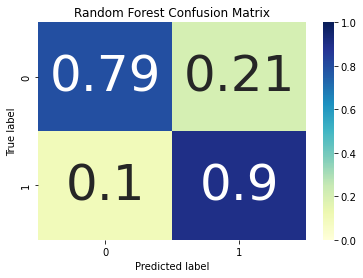

In [150]:
trained_df= df[['ChestPainType_ASY', 'ST_Slope_Flat', 'ST_Slope_Up', 'scaled_MaxHR', 'scaled_Oldpeak', 'HeartDisease']]
y3 = trained_df[['HeartDisease']]
X3 = trained_df.drop('HeartDisease', axis=1)
y3 = y3.values.ravel()

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state = 17, test_size = 0.3)
rf2 = RandomForestClassifier(n_estimators=100, 
                                criterion='gini', 
                                max_features='log2', 
                                max_depth=5, 
                                n_jobs=2,
                                random_state=17)
rf2.fit(X_train3, y_train3)
print('The train accuracy score', rf2.score(X_train3,y_train3))
print('The test accuracy score', rf2.score(X_test3,y_test3))
ran_for_proba = rf2.predict_proba(X_test3)
ran_for_proba = ran_for_proba[:,1]
print('')
print('Classification Report for Random Forest model')
print(classification_report(y_test3, rf2.predict(X_test3)))
print(rf2.classes_)
cm2 = confusion_matrix(y_test3, rf2.predict(X_test3))
cm_norm2 = cm2 / cm2.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm2, rf2.classes_)
plt.title('Random Forest Confusion Matrix')

In [152]:
print('Log Loss from train set: ',log_loss(y_train3, rf2.predict_proba(X_train3)))
print('Log Loss from test set: ',log_loss(y_test3, rf2.predict_proba(X_test3)))

Log Loss from train set:  0.2763704772519303
Log Loss from test set:  0.38153383393355267


This model is much stronger than the Logistic Regression. Not only is the True Positive rate at 90% but the False Negative rate (Type II Error) is significantly lower than the other model at 10%. This model is performing much better than the Logistic Regression model but the Type II error is still too high for my liking, so I will try one last model.

# K-Nearest Neighbors

The final model I will try is K-Nearest Neighbors. To start, I will use a for loop to go through a range of neighbors from 1 through 19 and analyze each neighbors score to see what number of neighbors has the best score.

In [138]:
knn_scores = []
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=10)
    knn_scores.append(score.mean())

Text(0.5, 1.0, 'Scores of KNN Model for different K')

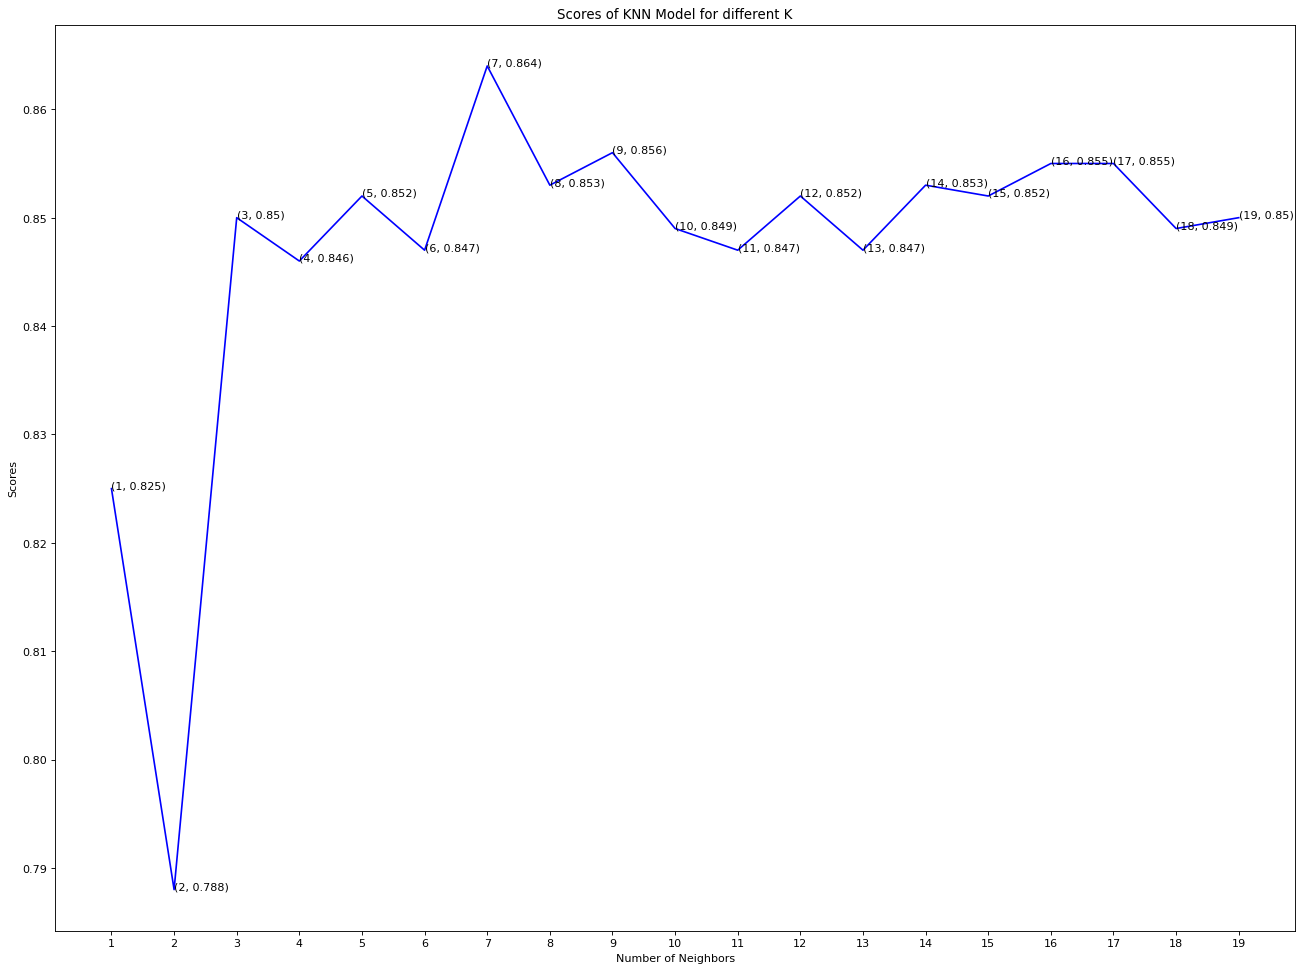

In [156]:
knn_scores = list(np.around(np.array(knn_scores),3))
figure(figsize=(20, 15), dpi=80)

plt.plot([k for k in range(1,20)], knn_scores, color='blue')
for i in range(1,20):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1,20)])
plt.xlabel('Number of Neighbors')
plt.ylabel('Scores')
plt.title('Scores of KNN Model for different K')

The best K number if neighbors is 7 based on the chart above with an accuracy score of 0.864.

In [164]:
knn2 = KNeighborsClassifier(n_neighbors=7)
knn2.fit(X_train, y_train)
knn2.predict(X_test)
knn_proba = knn2.predict_proba(X_test)
knn_proba = knn_proba[:,1]

In [159]:
print('The train accuracy score', knn2.score(X_train,y_train))
print('The test accuracy score', knn2.score(X_test,y_test))
print('')
print('Classification Report for Test set')
print(classification_report(y_test, knn2.predict(X_test)))

The train accuracy score 0.8829953198127926
The test accuracy score 0.8369565217391305

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       126
           1       0.82      0.89      0.86       150

    accuracy                           0.84       276
   macro avg       0.84      0.83      0.83       276
weighted avg       0.84      0.84      0.84       276



In [160]:
print('Log Loss from train set: ',log_loss(y_train, knn2.predict_proba(X_train)))
print('Log Loss from test set: ',log_loss(y_test, knn2.predict_proba(X_test)))

Log Loss from train set:  0.2567398438983905
Log Loss from test set:  1.3855166196696929


Since the log loss for the test set is greater than 1, means that the predicted probability for that given class would be less than exp(-1) or around 0.368.

Text(0.5, 1.0, 'KNN Confusion Matrix')

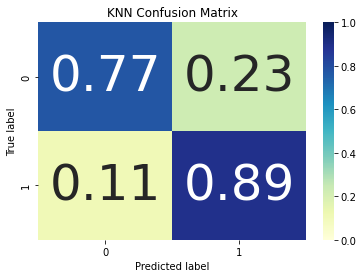

In [161]:
cm3 = confusion_matrix(y_test, knn2.predict(X_test))
cm_norm3 = cm3 / cm3.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm3, knn2.classes_)
plt.title('KNN Confusion Matrix')

The KNN model correctly predicted people with Heart Disease 89% of the time. It's accuracy is similar to the Random Forest Classifier.

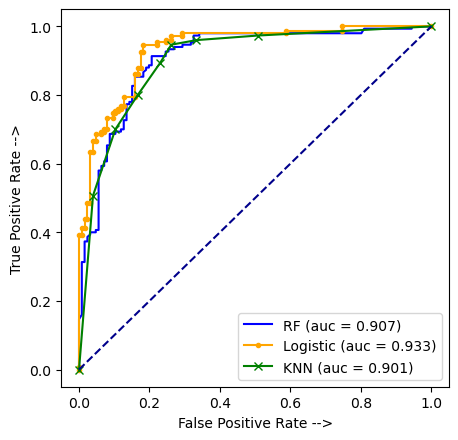

In [201]:
logistic_fpr, logistic_tpr, threshold_log = roc_curve(y_test2, log_reg_proba)
auc_logistic = auc(logistic_fpr, logistic_tpr)

rf_fpr, rf_tpr, threshold_rf = roc_curve(y_test3, ran_for_proba)
auc_rf = auc(rf_fpr, rf_tpr)

knn_fpr, knn_tpr, threshold_knn = roc_curve(y_test, knn_proba,)
auc_knn = auc(knn_fpr, knn_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(rf_fpr, rf_tpr, linestyle='-', label='RF (auc = %0.3f)' % auc_rf, color='blue')
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic, color='orange')
plt.plot(knn_fpr, knn_tpr, marker='x', label='KNN (auc = %0.3f)' % auc_knn, color='green')
plt.plot([0,1],[0,1], color='darkblue', linestyle='--')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [206]:
accuracy_log = []
for thres in threshold_log:
    y_pred = np.where(log_reg_proba>thres,1,0)
    accuracy_log.append(accuracy_score(y_test2, y_pred, normalize=True))
    
accuracy_log = pd.concat([pd.Series(threshold_log), pd.Series(accuracy_log)],
                        axis=1)
accuracy_log.columns = ['thresholds', 'accuracy']
accuracy_log.sort_values(by='accuracy', ascending=False, inplace=True)
log_thresh = accuracy_log['thresholds'].iloc[0]
log_accuracy = accuracy_log['accuracy'].iloc[0]

accuracy_rf = []
for thres in threshold_log:
    y_pred = np.where(ran_for_proba>thres,1,0)
    accuracy_rf.append(accuracy_score(y_test3, y_pred, normalize=True))
    
accuracy_rf = pd.concat([pd.Series(threshold_log), pd.Series(accuracy_rf)],
                        axis=1)
accuracy_rf.columns = ['thresholds', 'accuracy']
accuracy_rf.sort_values(by='accuracy', ascending=False, inplace=True)
rf_thresh = accuracy_rf['thresholds'].iloc[0]
rf_accuracy = accuracy_rf['accuracy'].iloc[0]

accuracy_knn = []
for thres in threshold_log:
    y_pred = np.where(knn_proba>thres,1,0)
    accuracy_knn.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_knn = pd.concat([pd.Series(threshold_log), pd.Series(accuracy_knn)],
                        axis=1)
accuracy_knn.columns = ['thresholds', 'accuracy']
accuracy_knn.sort_values(by='accuracy', ascending=False, inplace=True)
knn_thresh = accuracy_knn['thresholds'].iloc[0]
knn_accuracy = accuracy_knn['accuracy'].iloc[0]

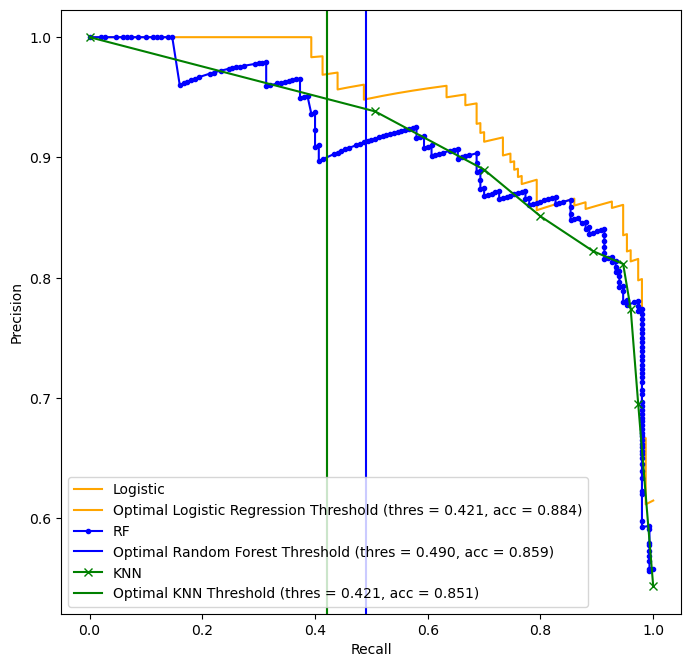

In [220]:
logistic_precision, logistic_recall, logistic_threshold = precision_recall_curve(y_test2, log_reg_proba)

rf_precision, rf_recall, rf_threshold = precision_recall_curve(y_test3, ran_for_proba)

knn_precision, knn_recall, knn_threshold = precision_recall_curve(y_test, knn_proba)

plt.figure(figsize=(8, 8), dpi=100)
plt.plot(logistic_recall,logistic_precision, linestyle='-', label='Logistic', color='orange')
plt.axvline(x=log_thresh, color='orange', label='Optimal Logistic Regression Threshold (thres = %0.3f, acc = %0.3f)' % (log_thresh, log_accuracy))

plt.plot(rf_recall,rf_precision, marker='.', label='RF', color='blue')
plt.axvline(x=rf_thresh, color='blue', label='Optimal Random Forest Threshold (thres = %0.3f, acc = %0.3f)' % (rf_thresh, rf_accuracy))

plt.plot(knn_recall,knn_precision, marker='x', label='KNN', color='green')
plt.axvline(x=knn_thresh, color='green', label='Optimal KNN Threshold (thres = %0.3f, acc = %0.3f)' % (knn_thresh, knn_accuracy))


plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()

plt.show()